<a href="https://colab.research.google.com/github/KorvenDalas/PADM/blob/main/CW2_PADM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Individual Empirical Report
w1834001

In [1]:
pip install pmdarima==2.0.4

# Data

In [2]:
# pmdarima V2.0.4 is compatible with numpy without raising any warning

## --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm

from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [3]:
# Loading weather dataset
london_weather = pd.read_csv('https://raw.githubusercontent.com/KorvenDalas/PADM/refs/heads/main/CW2%20-%20London%20Weather.csv')

In [4]:
# Change 'date' column to to datetime format
london_weather['date'] = pd.to_datetime(london_weather['date'], format = '%Y%m%d')

# Set the date column as the index
london_weather.set_index('date', inplace = True)

In [5]:
# Selecting the most recent 10 years of the dataset (2010-2020)
start_date = '2010-01-01'
end_date = '2020-12-31'

# Filter the dataframe based on the date range
london_weather = london_weather.loc[start_date : end_date]

In [6]:
# Download FTSE 100 data (last 10 years)
ftse = yf.download('^FTSE', start = start_date, end = end_date, interval = '1d')

# Flatten the MultiIndex columns
ftse.columns = [col[0] for col in ftse.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
# Merging datasets using a right join to retain only FTSE trading days
df = pd.merge(london_weather, ftse, left_index = True, right_index = True, how = 'right')

In [8]:
# Renaming the columns for better understanding of what are measuring and units
df = df.rename(columns={
    "cloud_cover": "Cloud_Cover_Oktas",
    "sunshine": "Sun_Hours",
    "global_radiation": "Solar_Rad_Wm2",
    "max_temp": "Max_Temp_C",
    "mean_temp": "Mean_Temp_C",
    "min_temp": "Min_Temp_C",
    "precipitation": "Precipitation_mm",
    "pressure": "Pressure_hPa",
    "snow_depth": "Snow_Depth_cm",
    "Close": "FTSE_Close",
    "High": "FTSE_High",
    "Low": "FTSE_Low",
    "Open": "FTSE_Open",
    "Volume": "FTSE_Trading_Volume"
})

In [9]:
# Analysis of missing values
missing_values = df.isnull().sum()
print(missing_values)

Cloud_Cover_Oktas        1
Sun_Hours                0
Solar_Rad_Wm2            5
Max_Temp_C               6
Mean_Temp_C              7
Min_Temp_C               2
Precipitation_mm         6
Pressure_hPa             0
Snow_Depth_cm          505
FTSE_Close               0
FTSE_High                0
FTSE_Low                 0
FTSE_Open                0
FTSE_Trading_Volume      0
dtype: int64


In [10]:
# Calculate missing data percentages
missing_percentage_snow = (df["Snow_Depth_cm"].isnull().sum() / len(df)) * 100
missing_percentage_temp = (df["Mean_Temp_C"].isnull().sum() / len(df)) * 100
print(f"% of NaN values in Snow_Depth_cm: {missing_percentage_snow:.2f}%")
print(f"% of NaN values in Mean_Temp_C: {missing_percentage_temp:.2f}%")

% of NaN values in Snow_Depth_cm: 18.19%
% of NaN values in Mean_Temp_C: 0.25%


In [11]:
# Drop feature with excessive missingness
df = df.drop(columns=["Snow_Depth_cm"])

# Interpolate missing values linearly
df = df.interpolate(method = 'linear')

# Recheck missing values
missing_values = df.isnull().sum()
print(missing_values)

Cloud_Cover_Oktas      0
Sun_Hours              0
Solar_Rad_Wm2          0
Max_Temp_C             0
Mean_Temp_C            0
Min_Temp_C             0
Precipitation_mm       0
Pressure_hPa           0
FTSE_Close             0
FTSE_High              0
FTSE_Low               0
FTSE_Open              0
FTSE_Trading_Volume    0
dtype: int64


In [12]:
# Remove the NaN value created with the shift function
df['Log_Return'] = np.log(df['FTSE_Close'] / df['FTSE_Close'].shift(1))
df.dropna(inplace = True)
df

,Cloud_Cover_Oktas,Sun_Hours,Solar_Rad_Wm2,Max_Temp_C,Mean_Temp_C,Min_Temp_C,Precipitation_mm,Pressure_hPa,FTSE_Close,FTSE_High,FTSE_Low,FTSE_Open,FTSE_Trading_Volume,Log_Return
Date,,,,,,,,,,,,,,
2010-01-05,7.0,0.1,15.0,1.0,-1.9,-5.9,2.0,100520.0,5522.500000,5536.399902,5480.700195,5500.299805,1149301200,0.004028
2010-01-06,7.0,0.0,13.0,0.1,-0.9,-2.8,2.6,100290.0,5530.000000,5536.500000,5497.700195,5522.500000,998295300,0.001357
2010-01-07,3.0,3.0,36.0,0.8,-2.8,-5.7,1.0,101160.0,5526.700195,5551.700195,5499.799805,5530.000000,1162933700,-0.000597
2010-01-08,4.0,2.1,31.0,1.7,-2.4,-5.6,0.2,102200.0,5534.200195,5549.299805,5494.799805,5526.700195,1006420600,0.001356
2010-01-11,8.0,0.0,14.0,1.8,0.9,0.1,1.4,101900.0,5538.100098,5600.500000,5527.899902,5534.200195,901194900,0.000704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-21,8.0,3.9,37.0,13.9,9.5,5.1,3.0,100770.0,6416.299805,6529.200195,6315.299805,6529.200195,1118314800,-0.017443
2020-12-23,7.0,0.0,23.0,14.0,12.0,10.1,1.8,100550.0,6495.799805,6497.299805,6431.200195,6453.200195,807695400,0.012314
2020-12-24,2.0,1.3,32.0,6.1,6.1,6.1,0.0,101830.0,6502.100098,6530.299805,6479.600098,6495.799805,477470700,0.000969


In [13]:
df.describe()

,Cloud_Cover_Oktas,Sun_Hours,Solar_Rad_Wm2,Max_Temp_C,Mean_Temp_C,Min_Temp_C,Precipitation_mm,Pressure_hPa,FTSE_Close,FTSE_High,FTSE_Low,FTSE_Open,FTSE_Trading_Volume,Log_Return
count,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2776.000000,2.776000e+03,2776.000000
mean,4.872298,4.231592,117.795389,16.057727,12.039157,8.020911,1.647839,101520.158501,6492.665341,6531.809370,6451.923131,6492.299852,8.115548e+08,0.000063
std,2.350923,4.001410,88.503527,6.633825,5.740147,5.284325,3.610392,1040.415601,710.229431,704.250961,717.483813,710.474537,2.720674e+08,0.010494
min,0.000000,0.000000,8.000000,-1.200000,-4.100000,-9.400000,0.000000,97310.000000,4805.799805,4863.399902,4790.000000,4805.799805,6.676710e+07,-0.115117
25%,3.000000,0.600000,40.000000,11.000000,7.700000,4.000000,0.000000,100920.000000,5896.749878,5933.000122,5860.949951,5896.274902,6.544344e+08,-0.004849
50%,5.000000,3.300000,94.000000,15.900000,12.000000,8.300000,0.000000,101610.000000,6547.549805,6583.750000,6507.450195,6547.149902,7.673317e+08,0.000484
75%,7.000000,6.800000,183.000000,21.000000,16.600000,12.200000,1.650000,102200.000000,7114.700195,7162.525024,7077.524902,7114.700195,8.988936e+08,0.005470
max,9.000000,16.000000,402.000000,37.900000,28.800000,22.300000,51.600000,104820.000000,7877.500000,7903.500000,7854.600098,7877.500000,3.761301e+09,0.086664


## Data Exploration

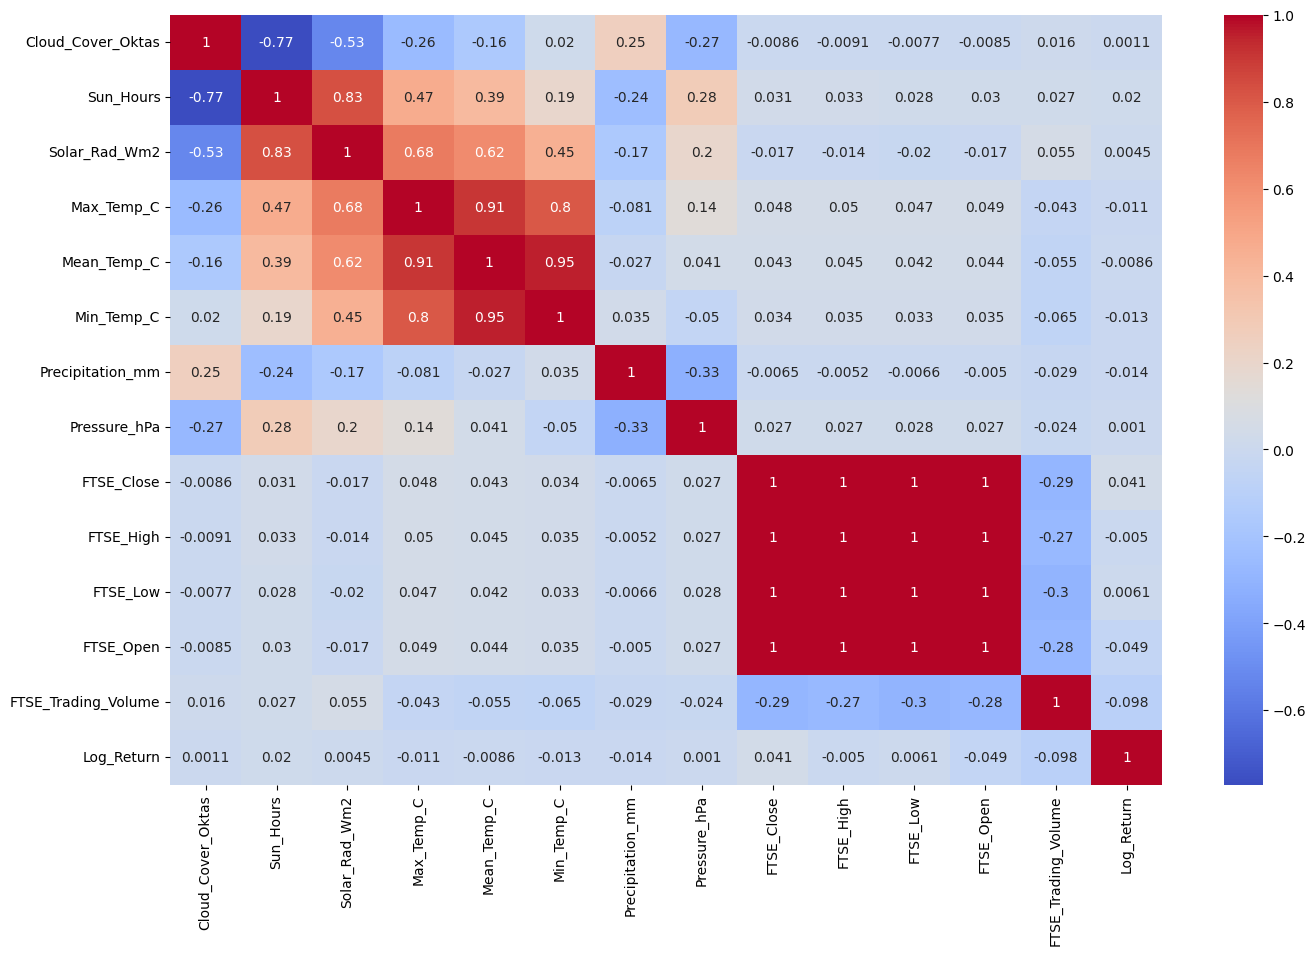

In [14]:
# Check for Correlation with Weather Variables
corr_matrix = df.corr()
plt.figure(figsize = (16, 10))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.show()

In [15]:
# Drop the highly correlated temperature and solar variables
df_reduced = df.drop(columns = [
    'Max_Temp_C',        # Highly correlated with Mean_Temp_C
    'Min_Temp_C',        # Highly correlated with Mean_Temp_C
    'Solar_Rad_Wm2',     # Highly correlated with Sun_Hours
    'FTSE_Open',         # Perfectly correlated with FTSE_Close
    'FTSE_High',         # Perfectly correlated with FTSE_Close
    'FTSE_Low'           # Perfectly correlated with FTSE_Close
])

In [16]:
df_reduced

,Cloud_Cover_Oktas,Sun_Hours,Mean_Temp_C,Precipitation_mm,Pressure_hPa,FTSE_Close,FTSE_Trading_Volume,Log_Return
Date,,,,,,,,
2010-01-05,7.0,0.1,-1.9,2.0,100520.0,5522.500000,1149301200,0.004028
2010-01-06,7.0,0.0,-0.9,2.6,100290.0,5530.000000,998295300,0.001357
2010-01-07,3.0,3.0,-2.8,1.0,101160.0,5526.700195,1162933700,-0.000597
2010-01-08,4.0,2.1,-2.4,0.2,102200.0,5534.200195,1006420600,0.001356
2010-01-11,8.0,0.0,0.9,1.4,101900.0,5538.100098,901194900,0.000704
...,...,...,...,...,...,...,...,...
2020-12-21,8.0,3.9,9.5,3.0,100770.0,6416.299805,1118314800,-0.017443
2020-12-23,7.0,0.0,12.0,1.8,100550.0,6495.799805,807695400,0.012314
2020-12-24,2.0,1.3,6.1,0.0,101830.0,6502.100098,477470700,0.000969


In [17]:
# Calculate price change
percentage_change = ((df_reduced['FTSE_Close'].iloc[-1] - (df_reduced['FTSE_Close'].iloc[0])) / (df_reduced['FTSE_Close'].iloc[0]) * 100)

print(f"Percentage change in Close Price in 10 Years: {percentage_change:.2f}%")

Percentage change in Close Price in 10 Years: 18.71%


In [18]:
# Count of days with positive/negative returns
positive_days = (df_reduced['Log_Return'] > 0).sum()
negative_days = (df_reduced['Log_Return'] < 0).sum()

print(f"Positive return days: {positive_days}")
print(f"Negative return days: {negative_days}")

Positive return days: 1450
Negative return days: 1322


## Data Visualisation

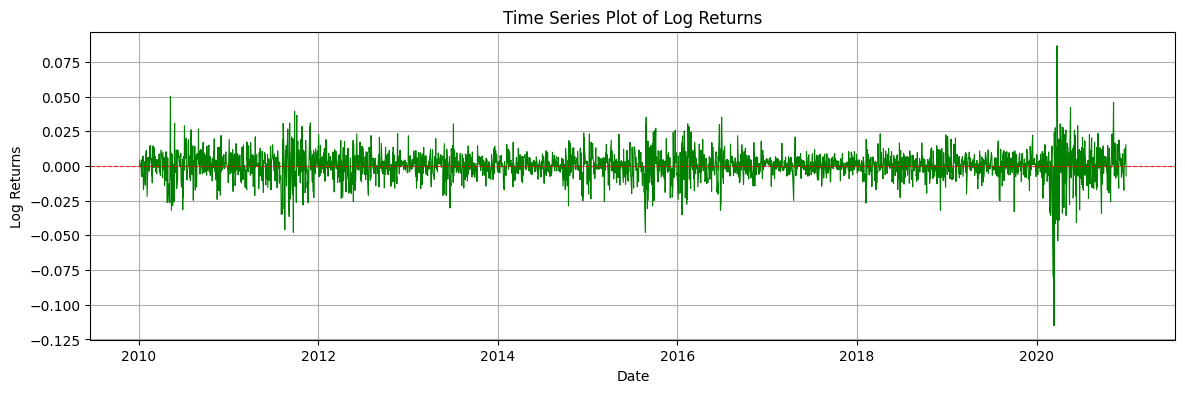

In [19]:
# Time Series Plot of Log Returns
plt.figure(figsize = (14, 4))
plt.plot(df_reduced['Log_Return'], linewidth = 0.8, color = 'green')
plt.axhline(y = 0, linestyle = '--', color = 'red', linewidth = 0.8, alpha = 0.8)
plt.title(f'Time Series Plot of Log Returns')
plt.ylabel('Log Returns')
plt.xlabel('Date')
plt.grid(True)
plt.show()

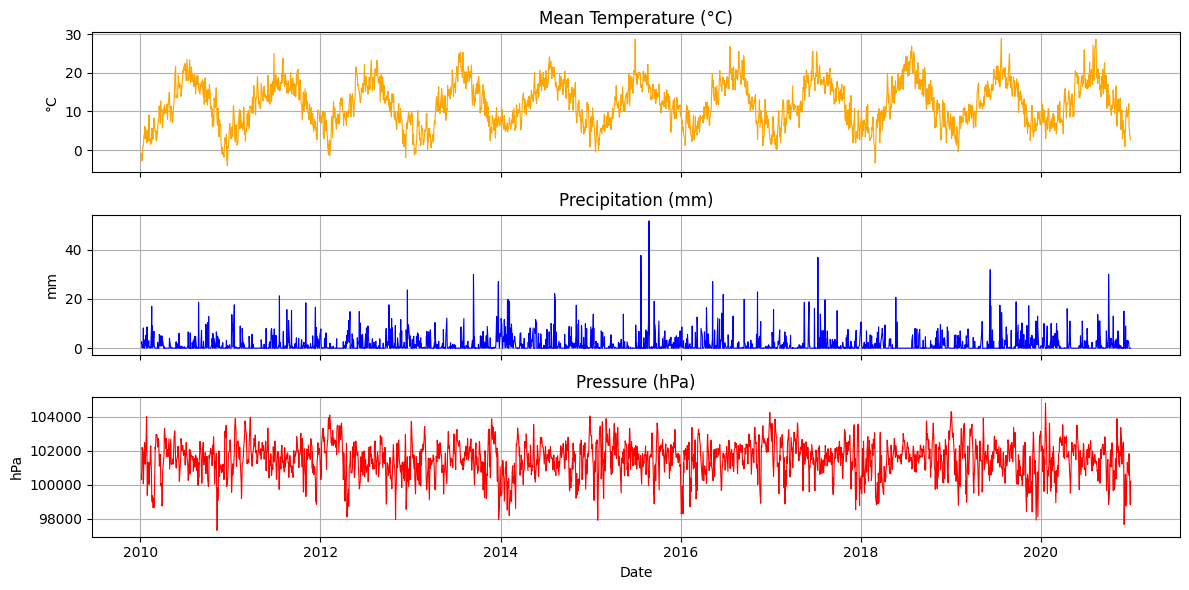

In [20]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize = (12, 6), sharex = True)

# Plot Mean Temperature
axs[0].plot(df_reduced.index, df_reduced['Mean_Temp_C'], color='orange', linewidth = 0.8)
axs[0].set_title('Mean Temperature (°C)')
axs[0].set_ylabel('°C')
axs[0].grid(True)

# Plot Precipitation
axs[1].plot(df_reduced.index, df_reduced['Precipitation_mm'], color='blue', linewidth = 0.8)
axs[1].set_title('Precipitation (mm)')
axs[1].set_ylabel('mm')
axs[1].grid(True)

# Plot Pressure
axs[2].plot(df_reduced.index, df_reduced['Pressure_hPa'], color='red', linewidth = 0.8)
axs[2].set_title('Pressure (hPa)')
axs[2].set_ylabel('hPa')
axs[2].grid(True)

# General settings
plt.xlabel('Date')
plt.tight_layout()
plt.show()

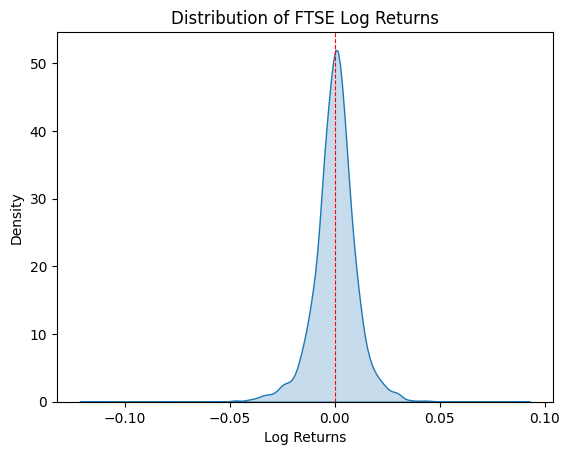

In [21]:
# KDE Plot of Log Returns
sns.kdeplot(df_reduced['Log_Return'], fill = True)
plt.axvline(x = 0, color = 'red', linestyle = '--', linewidth = 0.8)
plt.title('Distribution of FTSE Log Returns')
plt.xlabel('Log Returns')
plt.show()

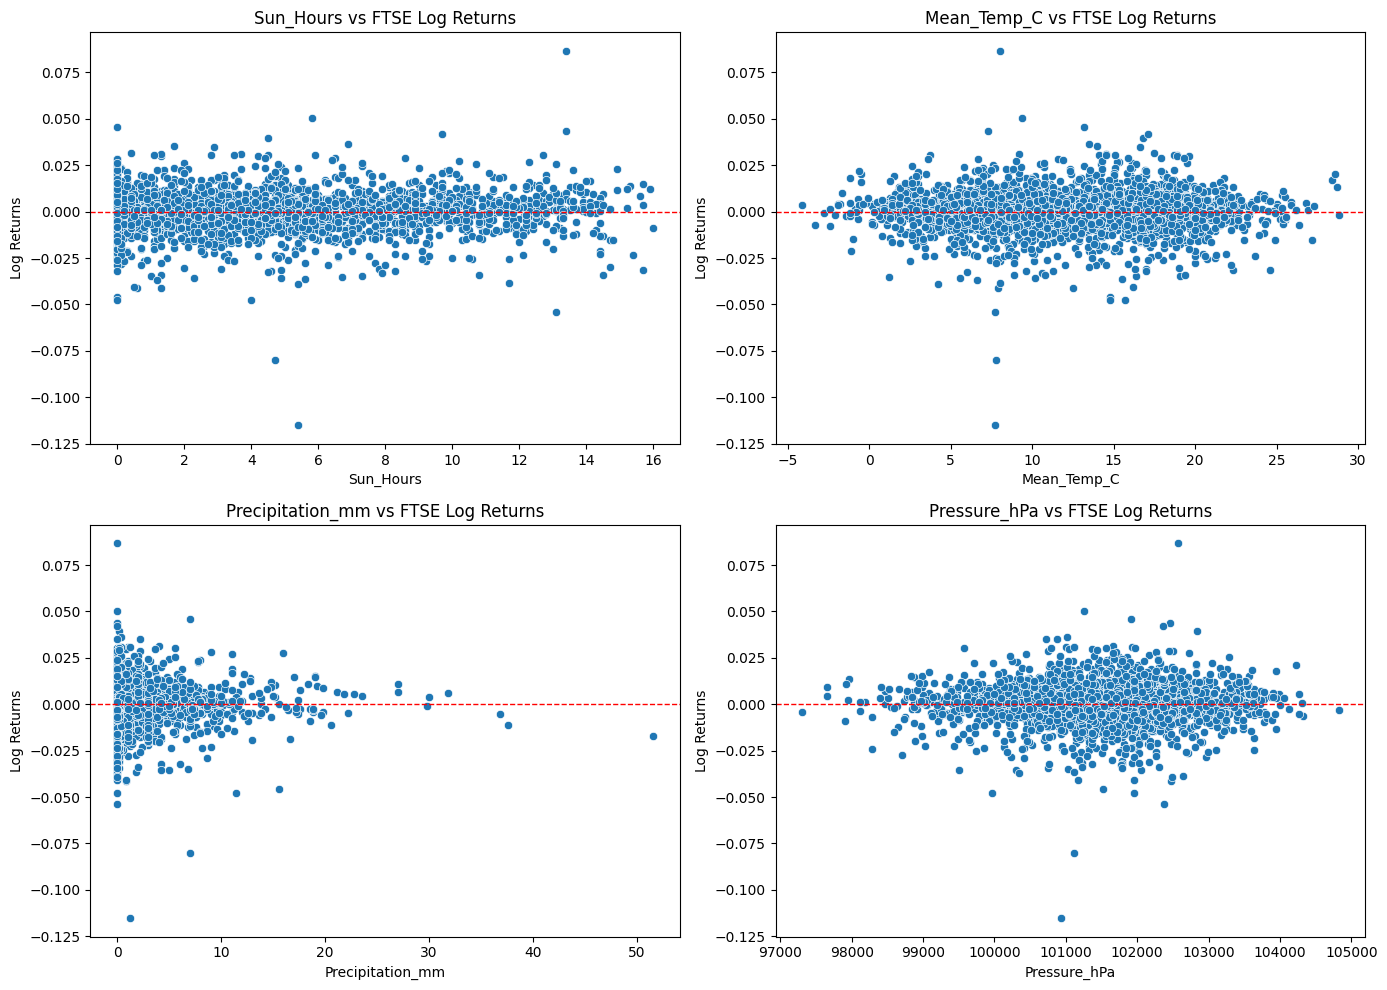

In [22]:
# List of weather variables
weather_vars = ['Sun_Hours', 'Mean_Temp_C', 'Precipitation_mm', 'Pressure_hPa']

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()  # Flatten the 2D array of axes to iterate easily

# Create scatterplots
for i, var in enumerate(weather_vars):
    sns.scatterplot(x = var, y = 'Log_Return', data = df_reduced, ax = axs[i])
    axs[i].axhline(y = 0, linestyle = '--', color = 'red', linewidth = 1)
    axs[i].set_title(f'{var} vs FTSE Log Returns')
    axs[i].set_ylabel('Log Returns')
    axs[i].set_xlabel(var)

# Adjust layout
plt.tight_layout()
plt.show()

# Modelling

In [23]:
# Define target and exogenous variables
y = df_reduced['Log_Return']
exog = df_reduced[['Cloud_Cover_Oktas',	'Sun_Hours', 'Mean_Temp_C', 'Precipitation_mm', 'Pressure_hPa']]

# Scale exogenous variables
scaler = StandardScaler()
exog_scaled = scaler.fit_transform(exog)
exog_scaled = pd.DataFrame(exog_scaled, index = exog.index, columns = exog.columns)

In [24]:
# Check for Stationarity
result = adfuller(y)
print(f'ADF Statistic: {result[0]:.5f}')
print(f'p-value: {result[1]:.5f}')

# If p-value < 0.05, data is stationary
# If p-value > 0.05, apply differencing

ADF Statistic: -18.09576
p-value: 0.00000


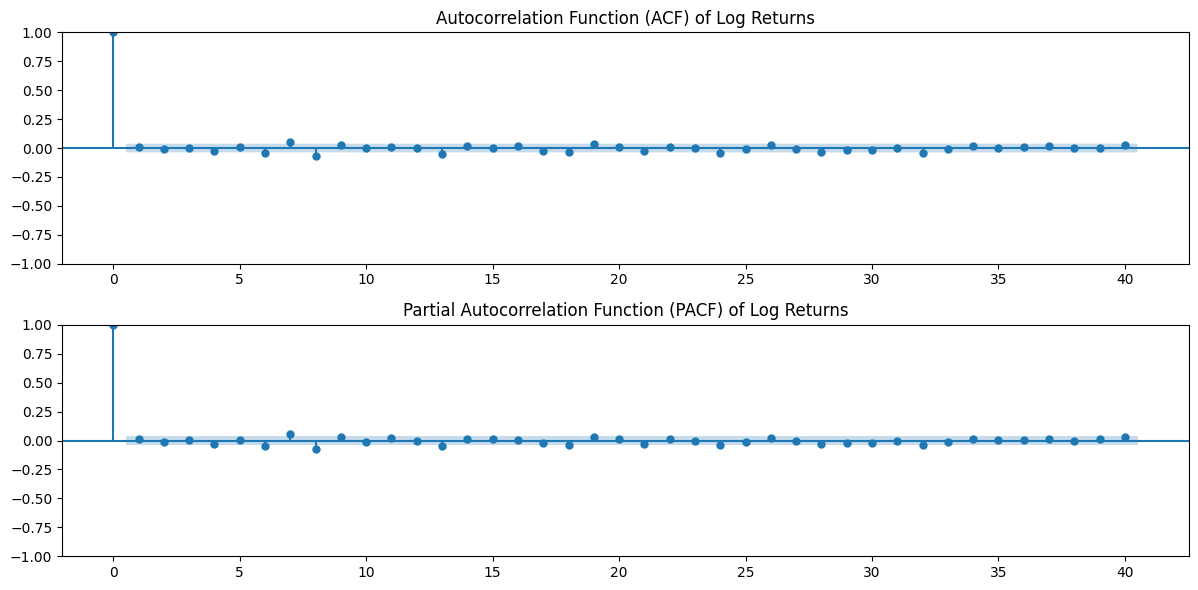

In [25]:
# Plot ACF and PACF
fig, axs = plt.subplots(2, 1, figsize = (12, 6))

plot_acf(y, lags = 40, ax = axs[0])
axs[0].set_title('Autocorrelation Function (ACF) of Log Returns')

plot_pacf(y, lags = 40, ax = axs[1])
axs[1].set_title('Partial Autocorrelation Function (PACF) of Log Returns')

plt.tight_layout()
plt.show()

In [26]:
# Auto ARIMA for model suggestion (non-seasonal)
test_no_season = auto_arima(y,
                             exogenous = exog_scaled,
                             start_p = 0,
                             start_q = 0,
                             test = 'adf',
                             seasonal = False,
                             suppress_warnings = True)
print(test_no_season.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2776
Model:               SARIMAX(1, 0, 1)   Log Likelihood                8717.906
Date:                Thu, 27 Mar 2025   AIC                         -17429.811
Time:                        14:55:50   BIC                         -17412.025
Sample:                             0   HQIC                        -17423.388
                               - 2776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8790      0.041    -21.373      0.000      -0.960      -0.798
ma.L1          0.9112      0.037     24.764      0.000       0.839       0.983
sigma2         0.0001   1.33e-06     82.371      0.0

In [27]:
# Non-seasonal order (p, d, q)
print('Autoarima Model suggested (p, d, q):', test_no_season.order)

Autoarima Model suggested (p, d, q): (1, 0, 1)


## ARIMAX (0, 0, 0)

In [28]:
model_no_season = SARIMAX(y,
                          exog = exog_scaled,
                          order = (0, 0, 0),
                          seasonal = False)

# Fits the model using maximum likelihood estimation.
model_no_season_fit = model_no_season.fit(disp = False)

print(model_no_season_fit.summary())
print('ARIMAX (0, 0, 0)')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 2776
Model:                        SARIMAX   Log Likelihood                8714.163
Date:                Thu, 27 Mar 2025   AIC                         -17416.327
Time:                        14:55:53   BIC                         -17380.754
Sample:                             0   HQIC                        -17403.481
                               - 2776                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Cloud_Cover_Oktas     0.0005      0.000      1.698      0.089   -8.01e-05       0.001
Sun_Hours             0.0007      0.000      2.401      0.016       0.000       0.001
Mean_Temp_C          -0.

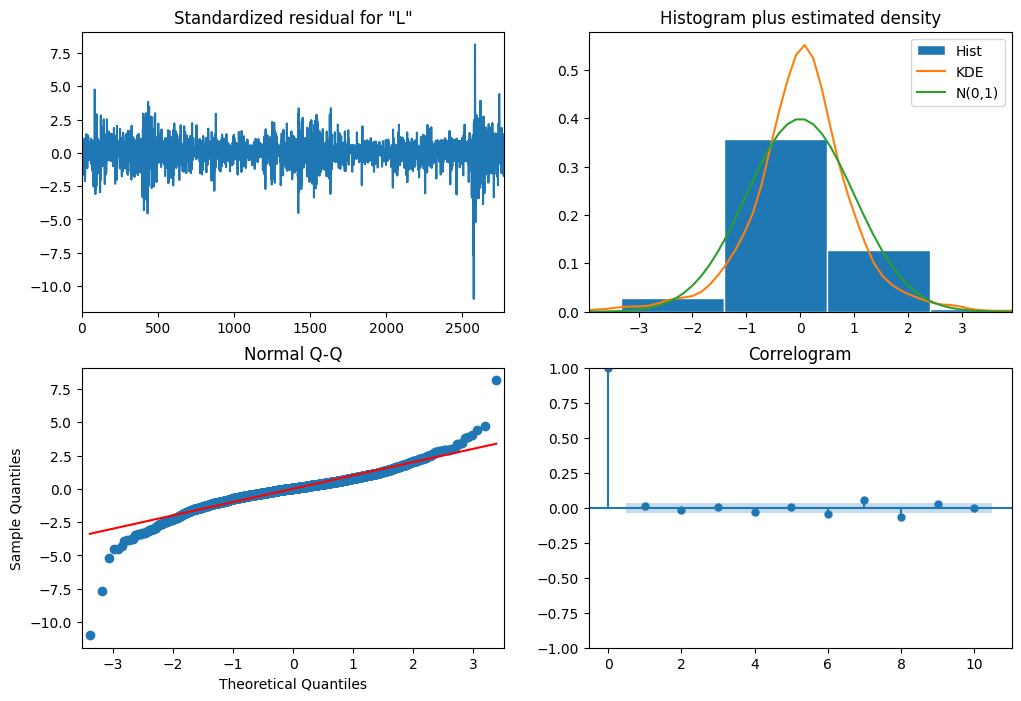

ARIMAX (0, 0, 0)


In [29]:
model_no_season_fit.plot_diagnostics(figsize = (12, 8))
plt.show()
print('ARIMAX (0, 0, 0)')

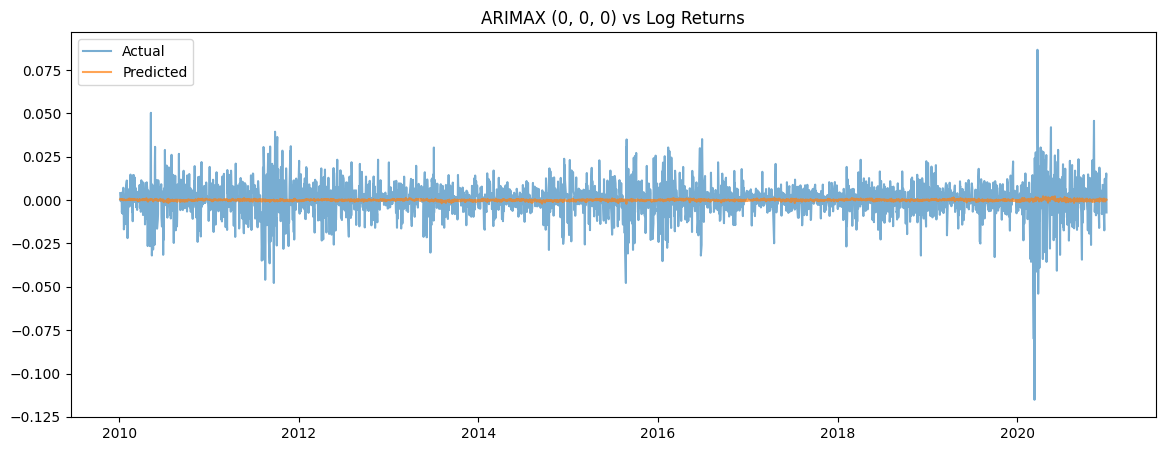

In [30]:
# Predictions and evaluation
y_pred = model_no_season_fit.predict(start = 0, end = len(y) - 1, exog = exog_scaled)

plt.figure(figsize = (14, 5))
plt.plot(y, label = 'Actual', alpha = 0.6)
plt.plot(y_pred, label = 'Predicted', alpha = 0.7)
plt.title('ARIMAX (0, 0, 0) vs Log Returns')
plt.legend()
plt.show()

In [31]:
rmse = []
rmse.append(np.sqrt(mean_squared_error(y, y_pred)))
print('ARIMAX (0, 0, 0)')
print(f'RMSE: {rmse[0]:.6f}')

ARIMAX (0, 0, 0)
RMSE: 0.010483


## ARIMAX (1, 0, 1)

In [32]:
model_no_season2 = SARIMAX(y,
                          exog = exog_scaled,
                          order = (1, 0, 1),
                          seasonal = False)

# Fits the model using maximum likelihood estimation.
model_no_season_fit2 = model_no_season2.fit(disp = False)

print(model_no_season_fit2.summary())
print('ARIMAX (1, 0, 1)')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 2776
Model:               SARIMAX(1, 0, 1)   Log Likelihood                8715.926
Date:                Thu, 27 Mar 2025   AIC                         -17415.852
Time:                        14:55:57   BIC                         -17368.422
Sample:                             0   HQIC                        -17398.724
                               - 2776                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Cloud_Cover_Oktas     0.0005      0.000      1.682      0.093   -8.73e-05       0.001
Sun_Hours             0.0007      0.000      2.356      0.018       0.000       0.001
Mean_Temp_C          -0.

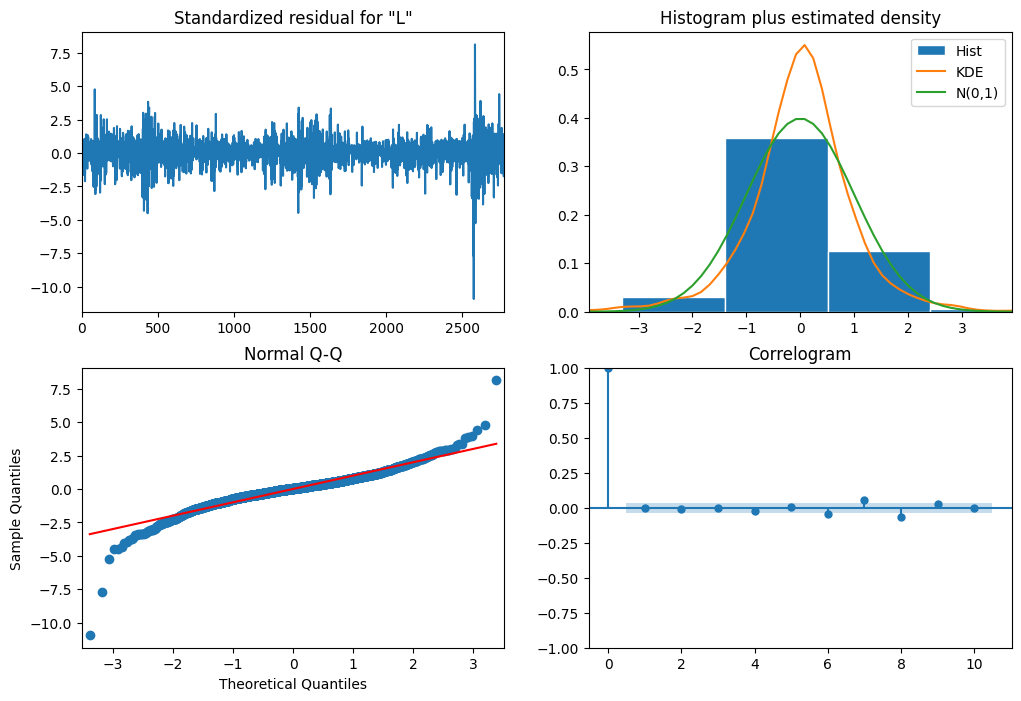

ARIMAX (1, 0, 1)


In [33]:
model_no_season_fit2.plot_diagnostics(figsize = (12, 8))
plt.show()
print('ARIMAX (1, 0, 1)')

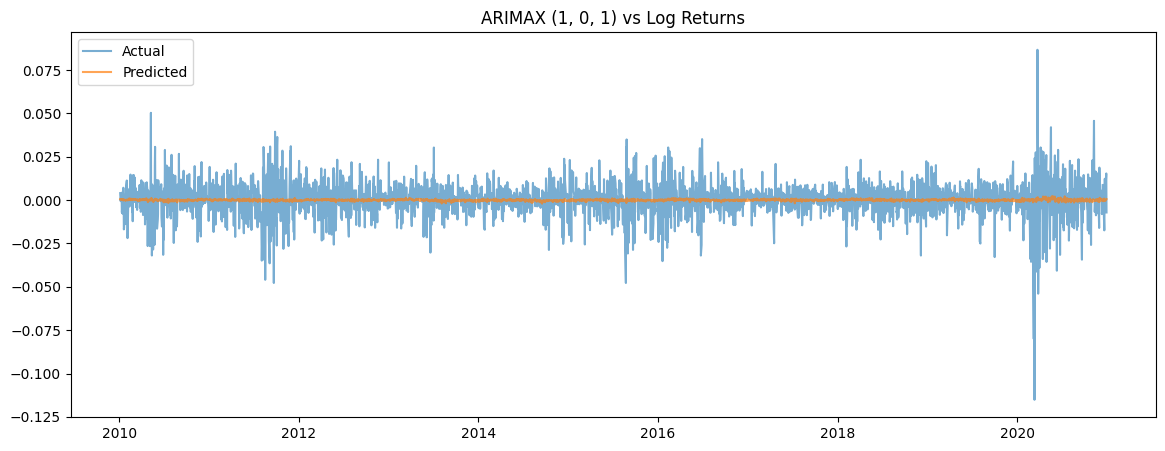

In [34]:
# Predictions and evaluation
y_pred2 = model_no_season_fit2.predict(start = 0, end = len(y) - 1, exog = exog_scaled)

plt.figure(figsize = (14, 5))
plt.plot(y, label = 'Actual', alpha = 0.6)
plt.plot(y_pred2, label = 'Predicted', alpha = 0.7)
plt.title('ARIMAX (1, 0, 1) vs Log Returns')
plt.legend()
plt.show()

In [35]:
rmse.append(np.sqrt(mean_squared_error(y, y_pred2)))
print('ARIMAX (1, 0, 1)')
print(f'RMSE: {rmse[1]:.6f}')

ARIMAX (1, 0, 1)
RMSE: 0.010476


## SARIMAX (1, 0, 1, 252) - Not working

In [36]:
# The seasonal model selection process became computationally intensive and led to excessive runtime and memory usage
# This step has been removed
'''
test_season = auto_arima(y,
                         exogenous = exog_scaled,
                         start_p = 0,
                         start_q = 0,
                         test = 'adf',
                         seasonal = True,
                         m = 252,  # Seasonal component, Num of entries in a cycle equal to the number of trading days in a year
                         stepwise = True,
                         suppress_warnings = True)
print(test_season.summary())
'''
print('Remove the comments if you want to run the searching of the optimal seasonal model')

Remove the comments if you want to run the searching of the optimal seasonal model


In [37]:
# Same as the previous step, it is computationally intensive and led to excessive runtime and memory usage
# This step has been removed
'''
model_season = SARIMAX(y,
                       exog = exog_scaled,
                       seasonal_order = (1, 0, 1, 252))
model_season_fit = model_season.fit(disp = False)
print(model_season_fit.summary())
'''
print('-')

-


## SARIMAX (1, 0, 1, 52) - Weekly

In [38]:
# Resample to weekly averages
df_weekly = df_reduced.resample('W').mean()

In [39]:
# Define new weekly target and exogenous variables
y_W = df_weekly['Log_Return']
exog_W = df_weekly[['Cloud_Cover_Oktas',	'Sun_Hours', 'Mean_Temp_C', 'Precipitation_mm', 'Pressure_hPa']]

# Scale exogenous variables
scaler = StandardScaler()
exog_scaled_W = scaler.fit_transform(exog_W)
exog_scaled_W = pd.DataFrame(exog_scaled_W, index = exog_W.index, columns = exog_W.columns)

In [40]:
model_seasonal_W = SARIMAX(y_W,
                         exog = exog_scaled_W,
                         order = (0, 0, 0),
                         seasonal_order = (1, 0, 1, 52))

# Fits the model using maximum likelihood estimation.
model_seasonal_fit_W = model_seasonal_W.fit(disp = False)

print(model_seasonal_fit_W.summary())
print('SARIMAX (1, 0, 1, 52) - Weekly')

                                 SARIMAX Results                                  
Dep. Variable:                 Log_Return   No. Observations:                  574
Model:             SARIMAX(1, 0, [1], 52)   Log Likelihood                2266.867
Date:                    Thu, 27 Mar 2025   AIC                          -4517.734
Time:                            14:56:13   BIC                          -4482.913
Sample:                        01-10-2010   HQIC                         -4504.152
                             - 01-03-2021                                         
Covariance Type:                      opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Cloud_Cover_Oktas    -0.0001      0.000     -0.389      0.697      -0.001       0.001
Sun_Hours             0.0003      0.000      0.781      0.435      -0.000     

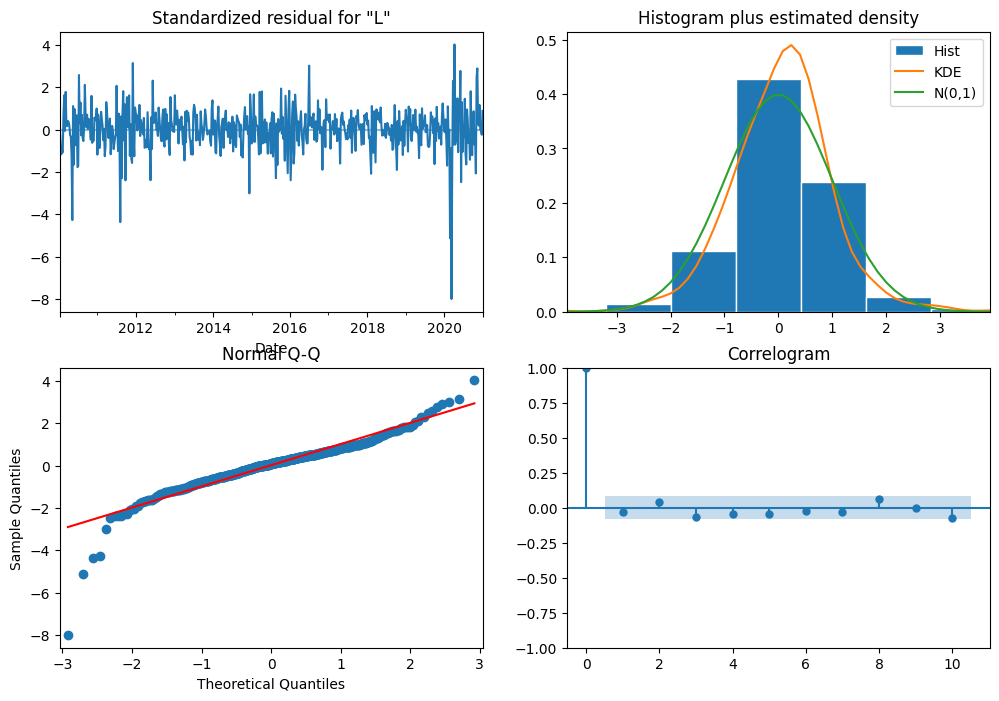

SARIMAX (1, 0, 1, 52) - Weekly


In [41]:
model_seasonal_fit_W.plot_diagnostics(figsize = (12, 8))
plt.show()
print('SARIMAX (1, 0, 1, 52) - Weekly')

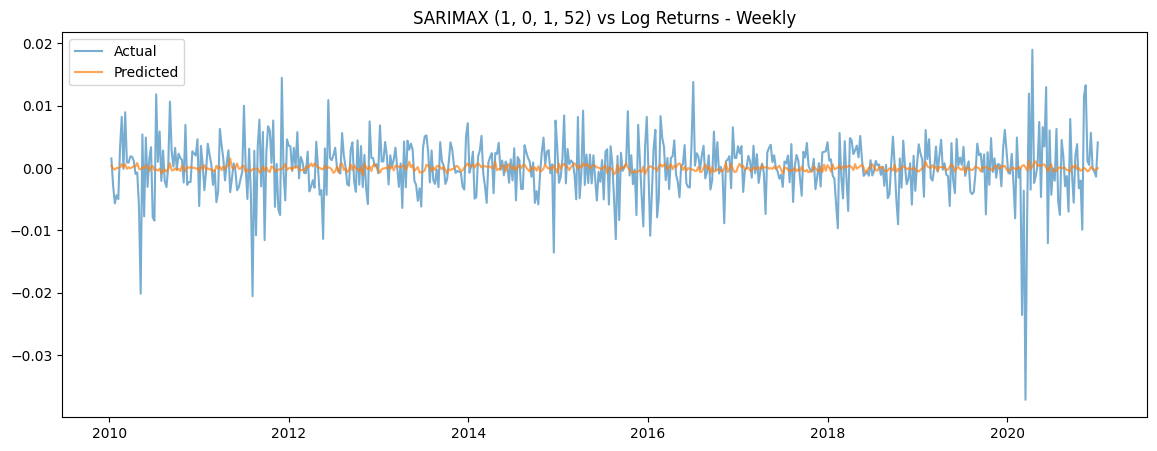

In [42]:
# Predictions and evaluation
y_pred_W = model_seasonal_fit_W.predict(start = 0, end = len(y_W) - 1, exog = exog_scaled_W)

plt.figure(figsize = (14, 5))
plt.plot(y_W, label = 'Actual', alpha = 0.6)
plt.plot(y_pred_W, label = 'Predicted', alpha = 0.7)
plt.title('SARIMAX (1, 0, 1, 52) vs Log Returns - Weekly')
plt.legend()
plt.show()

In [43]:
rmse.append(np.sqrt(mean_squared_error(y_W, y_pred_W)))
print('SARIMAX (1, 0, 1, 52) - Weekly')
print(f'RMSE: {rmse[2]:.6f}')

SARIMAX (1, 0, 1, 52) - Weekly
RMSE: 0.004663


# Conclusion

In [44]:
# Original std of Sun_Hours before scaling
sigma_sun = df_reduced['Sun_Hours'].std()

# Sun_Hours coefficient from the ARIMAX (0, 0, 0)
beta_std = model_no_season_fit.params['Sun_Hours']

# Convert to original scale
beta_original = beta_std / sigma_sun
print('Coefficient in original Sun_Hours units: ', beta_original)

Coefficient in original Sun_Hours units:  0.0001769272159362328


In [45]:
# Log return to approximate percentage change
percentage_change = (np.exp(beta_original) - 1) * 100

# Print interpretation
print(f'A one-hour increase in daily sunshine is associated with approximately {percentage_change:.4f}% increase in FTSE returns, holding  holding other variables constant')

A one-hour increase in daily sunshine is associated with approximately 0.0177% increase in FTSE returns, holding  holding other variables constant
